In [149]:
import numpy as np
import pandas as pd
import scipy.signal as ss
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams["figure.figsize"] = (8, 6)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [189]:
num_rows = 10000

# past attendance - left skewed
past_attend = np.clip(np.cbrt(np.random.normal(loc = 0.8, scale = 0.1, size = num_rows)), 0, 1)

# age - uniform
age = np.random.randint(low = 18, high = 90, size = num_rows)

log_odds = -1.7*past_attend**3 + -.02*age + 0

prob_noshow = sigmoid(log_odds)

Text(0, 0.5, 'number patients')

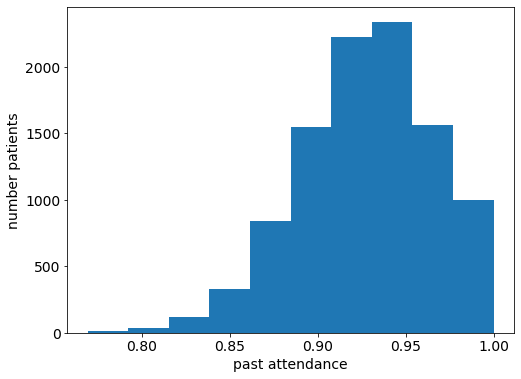

In [190]:
plt.hist(past_attend)
plt.xlabel('past attendance')
plt.ylabel('number patients')

Text(0, 0.5, 'p(noshow)')

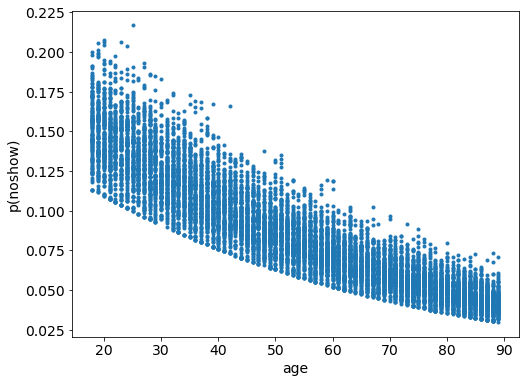

In [191]:
plt.plot(age, prob_noshow, '.')
plt.xlabel('age')
plt.ylabel('p(noshow)')

Text(0, 0.5, 'p(no show)')

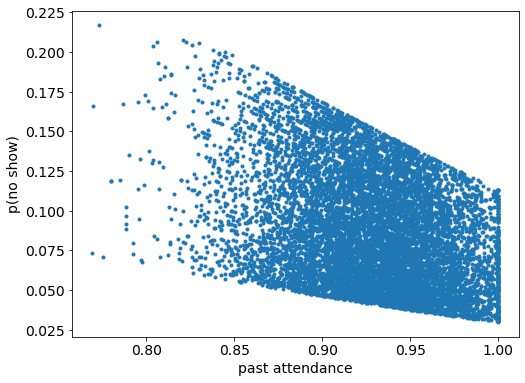

In [192]:
plt.plot(past_attend, prob_noshow, '.')
plt.xlabel('past attendance')
plt.ylabel('p(no show)')

Text(0, 0.5, 'number patients')

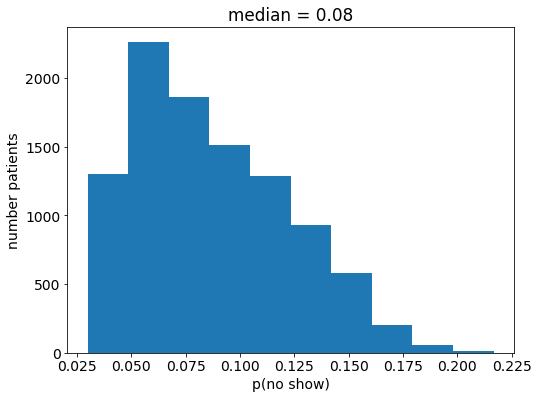

In [193]:
plt.hist(prob_noshow)
plt.title('median = {x:.2f}'.format(x=np.median(prob_noshow)))
plt.xlabel('p(no show)')
plt.ylabel('number patients')

In [217]:
out = []
for x in range(90):
    out.append(np.random.choice(prob_noshow,size=16,replace=False))

In [218]:
new = []
for x in range(len(out)):
    new.append(sum(out[x]))

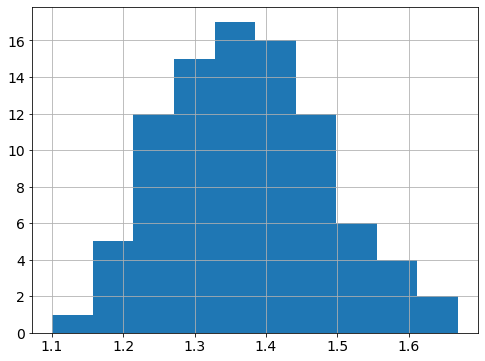

In [219]:
pd.Series(new).hist()

Text(0, 0.5, 'number patients')

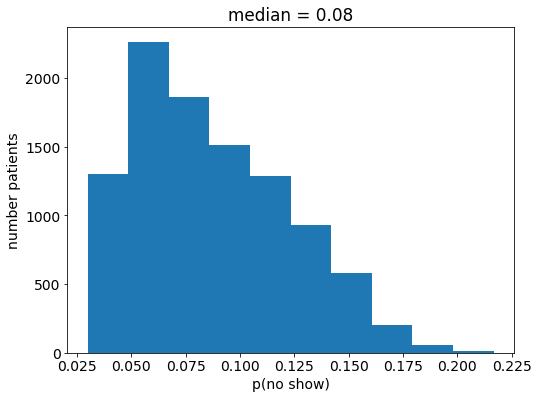

In [193]:
plt.hist(prob_noshow)
plt.title('median = {x:.2f}'.format(x=np.median(prob_noshow)))
plt.xlabel('p(no show)')
plt.ylabel('number patients')

In [194]:
# Put data in dataframe and impute no shows
df = pd.DataFrame(data = np.concatenate((past_attend.reshape(-1,1), 
                                         age.reshape(-1,1), 
                                         prob_noshow.reshape(-1,1)),
                                        axis=1),
                  columns = ['past_attendance','age','p_noshow'])

for i in np.arange(0,df.shape[0]):
    df.loc[i, 'noshow'] = np.random.choice([0,1], p=[1-df.loc[i,'p_noshow'], df.loc[i,'p_noshow']])

In [195]:
df['p_noshow'].sum(), df['noshow'].sum()

(873.106967743226, 886.0)

In [196]:
# For daily appointments, calculate the number of realized appointments
sum_realized_appts = []
noshows = []
patients = []

num_slots_per_day = 16
num_days = 90
for i in np.arange(0,num_days):
    chosen_rows = np.random.choice(np.arange(0,df.shape[0]),size=num_slots_per_day, replace=False)
    sum_realized_appts.append(np.sum(1-df.loc[chosen_rows,'p_noshow']))
    patients.append(df.loc[chosen_rows,:])
    noshows.append(df.loc[chosen_rows,'noshow'].sum())

Text(0, 0.5, 'number of realized appts')

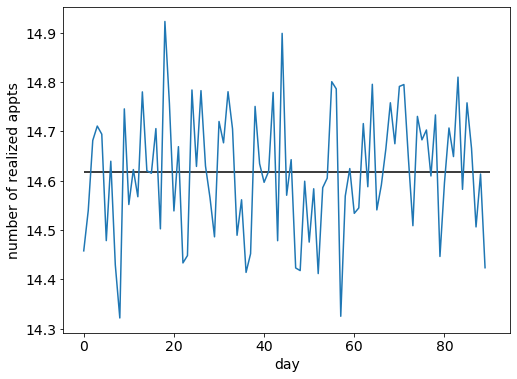

In [197]:
plt.plot(sum_realized_appts)
plt.hlines(np.mean(sum_realized_appts),0,90)
plt.xlabel('day')
plt.ylabel('number of realized appts')

In [198]:
# About what we expect 
16*(1-np.median(df.p_noshow))

14.702013699446237

Text(0, 0.5, '# no shows')

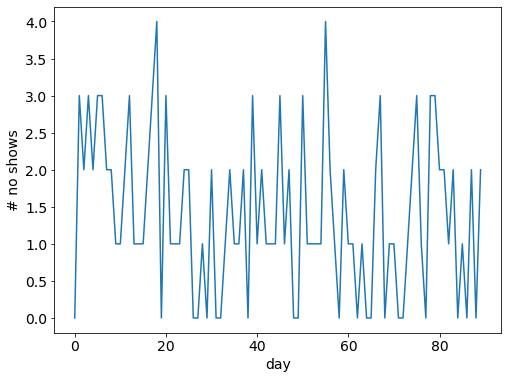

In [199]:
# days vs. number of no shows
plt.plot(noshows)
plt.xlabel('day')
plt.ylabel('# no shows')

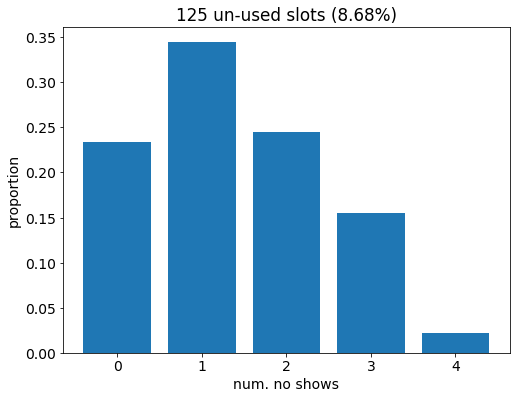

In [200]:
n,b = np.histogram(np.array(noshows),bins=[0,1,2,3,4,5])
plt.bar(b[1:],n/np.sum(n))
plt.xticks(ticks=[1,2,3,4,5],labels=['0','1','2','3','4'])
plt.xlabel('num. no shows')
plt.ylabel('proportion')
plt.title('{} un-used slots ({u:.2f}%)'.format(np.sum(n[1:]*[1,2,3,4]),
                                          u=100*np.sum(n[1:]*[1,2,3,4])/(num_slots_per_day*num_days)))
plt.show()

In [201]:
# Let's overbook by 1 appointment every day
sum_realized_appts = []
noshows = []
patients = []

num_slots_per_day = 17
num_days = 90
for i in np.arange(0,num_days):
    chosen_rows = np.random.choice(np.arange(0,df.shape[0]),size=num_slots_per_day, replace=False)
    sum_realized_appts.append(np.sum(1-df.loc[chosen_rows,'p_noshow']))
    patients.append(df.loc[chosen_rows,:])
    noshows.append(df.loc[chosen_rows,'noshow'].sum())

Text(0, 0.5, 'number of realized appts')

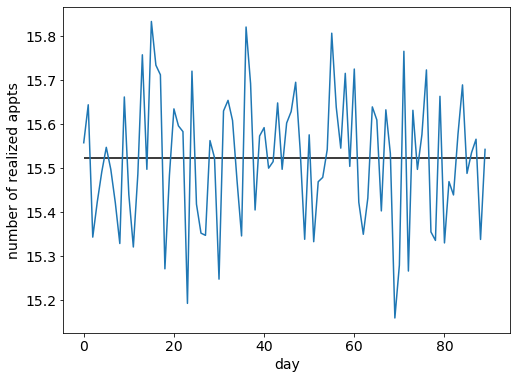

In [202]:
plt.plot(sum_realized_appts)
plt.hlines(np.mean(sum_realized_appts),0,90)
plt.xlabel('day')
plt.ylabel('number of realized appts')

Text(0, 0.5, '# no shows')

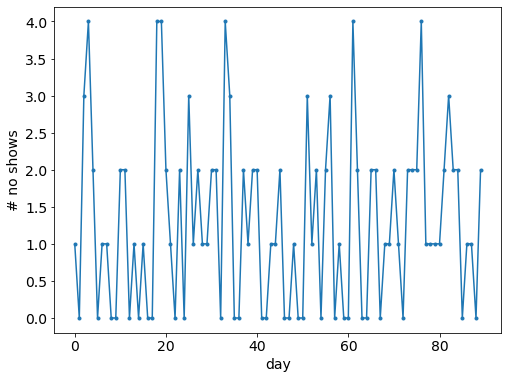

In [203]:
# Here we actually want 1 or more no-shows. 
plt.plot(noshows,marker='.')
plt.xlabel('day')
plt.ylabel('# no shows')

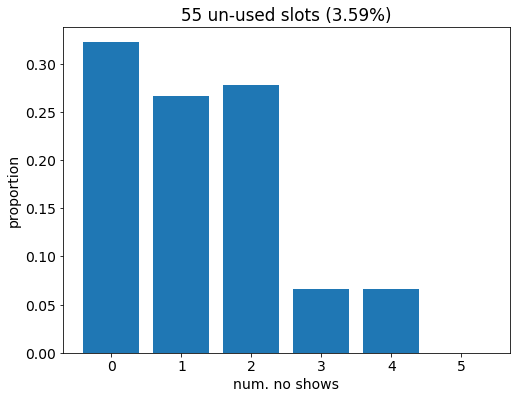

In [204]:
n,b = np.histogram(np.array(noshows),bins=[0,1,2,3,4,5,6])
plt.bar(b[1:],n/np.sum(n))
plt.xticks(ticks=[1,2,3,4,5,6],labels=['0','1','2','3','4','5'])
plt.xlabel('num. no shows')
plt.ylabel('proportion')
plt.title('{} un-used slots ({u:.2f}%)'.format(np.sum(n[2:]*[1,2,3,4]),
                                          u=100*np.sum(n[2:]*[1,2,3,4])/(num_slots_per_day*num_days)))
plt.show()

In [ ]:
# Using the over-book every day policy cuts your number of un-used slots in half, but you have to deal with
#    the proportion of days we'll have to bump someone because everyone shows up

In [ ]:
# What policies could keep the un-used slots down but also decrease the days where we have to deal 
#    with everyone showing up?

In [50]:
# Let's put all "high risk" patients on even days, "low risk" patients on odd
q = np.quantile(df.p_noshow,[0,0.25,0.5,0.75])

df_low_risk = df.loc[df.p_noshow<q[2],:].reset_index(drop=True).copy()
df_high_risk = df.loc[df.p_noshow>=q[2],:].reset_index(drop=True).copy()

sum_realized_appts = []
noshows = []
patients = []
for i in np.arange(0,90):
    if np.mod(i,2)==0:
        # Over book by 1
        chosen_rows = np.random.choice(np.arange(0,df_high_risk.shape[0]),size=17, replace=False)
        sum_realized_appts.append(np.sum(1-df_high_risk.loc[chosen_rows,'p_noshow']))
        patients.append(df_high_risk.loc[chosen_rows,:])
        noshows.append(df_high_risk.loc[chosen_rows,'noshow'].sum())
    else:
        # Book exact number needed
        chosen_rows = np.random.choice(np.arange(0,df_low_risk.shape[0]),size=16, replace=False)
        sum_realized_appts.append(np.sum(1-df_low_risk.loc[chosen_rows,'p_noshow']))
        patients.append(df_low_risk.loc[chosen_rows,:])
        noshows.append(df_low_risk.loc[chosen_rows,'noshow'].sum())

Text(0, 0.5, 'number of realized appts')

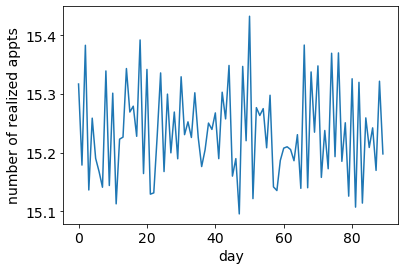

In [51]:
plt.plot(sum_realized_appts)
plt.xlabel('day')
plt.ylabel('number of realized appts')

In [58]:
even_days = np.arange(0,90,2)
odd_days = np.arange(1,90,2)

Text(0.5, 1.0, '47.0 un-used slots')

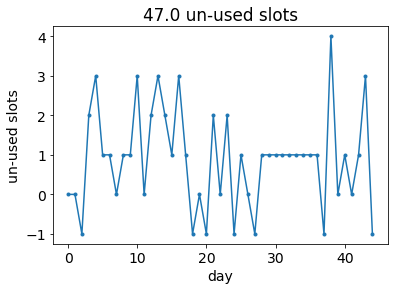

In [74]:
# Even days are over booked so we want at least 1 no show
x = np.array(noshows)[np.isin(np.arange(0,90),even_days)]-1
plt.plot(x, marker='.')
plt.xlabel('day')
plt.ylabel('un-used slots')
plt.title('{} un-used slots'.format(x[x>0].sum()))

Text(0.5, 1.0, '28.0 un-used slots')

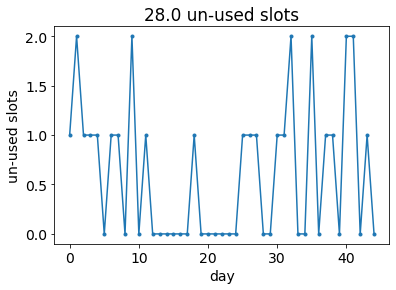

In [68]:
# odd days are exact booked
x = np.array(noshows)[np.isin(np.arange(0,90),odd_days)]
plt.plot(x, marker='.')
plt.xlabel('day')
plt.ylabel('un-used slots')
plt.title('{} un-used slots'.format(x[x>0].sum()))

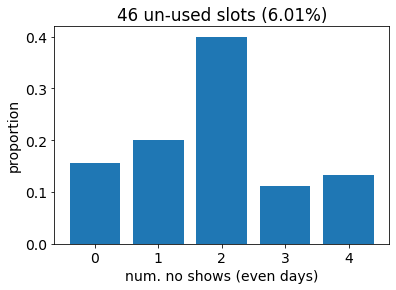

In [72]:
n,b = np.histogram(np.array(np.array(noshows)[np.isin(np.arange(0,90),even_days)]),bins=[0,1,2,3,4,5])
plt.bar(b[1:],n/np.sum(n))
plt.xticks(ticks=[1,2,3,4,5],labels=['0','1','2','3','4'])
plt.xlabel('num. no shows (even days)')
plt.ylabel('proportion')
plt.title('{} un-used slots ({u:.2f}%)'.format(np.sum(n[2:]*[1,2,3]),
                                          u=100*np.sum(n[2:]*[1,2,3])/(num_slots_per_day*num_days/2)))
plt.show()

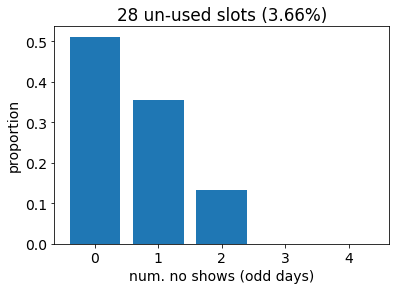

In [73]:
n,b = np.histogram(np.array(np.array(noshows)[np.isin(np.arange(0,90),odd_days)]),bins=[0,1,2,3,4,5])
plt.bar(b[1:],n/np.sum(n))
plt.xticks(ticks=[1,2,3,4,5],labels=['0','1','2','3','4'])
plt.xlabel('num. no shows (odd days)')
plt.ylabel('proportion')
plt.title('{} un-used slots ({u:.2f}%)'.format(np.sum(n[1:]*[1,2,3,4]),
                                          u=100*np.sum(n[1:]*[1,2,3,4])/(num_slots_per_day*num_days/2)))
plt.show()

In [437]:
chosen_rows = np.random.choice(np.arange(0,df.shape[0]),size=16, replace=False)
day1 = df.loc[chosen_rows,:].sort_values(by='p_noshow').reset_index(drop=True)
chosen_rows = np.random.choice(np.arange(0,df.shape[0]),size=16, replace=False)
day2 = df.loc[chosen_rows,:].sort_values(by='p_noshow').reset_index(drop=True)

In [438]:
day1['p_noshow'].median()

0.0656519686923408

In [442]:
day1_new = pd.concat((day1.loc[8:,:],day2.loc[8:,:]),axis=0)
day2_new = pd.concat((day1.loc[:7,:],day2.loc[:7,:]),axis=0)

In [443]:
day1_new.shape, day2_new.shape

((16, 4), (16, 4))

In [445]:
np.sum(1-day1_new['p_noshow']), np.sum(1-day2_new['p_noshow'])

(14.587218688188521, 15.276790928518915)

In [354]:
day1_app

,past_attendance,age,p_noshow,noshow
1810,0.705000,85.0,0.059664,0.0
7988,0.724186,30.0,0.156266,0.0
6584,0.978310,71.0,0.052777,0.0
8205,0.765623,72.0,0.069886,0.0
151,0.890008,22.0,0.144920,0.0
2876,0.980574,89.0,0.037296,0.0
9794,0.956083,33.0,0.109669,0.0
966,1.000000,25.0,0.119203,0.0
8353,0.902894,72.0,0.057631,0.0
